In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

#### Preprocessing the Data

In [5]:
# Load datasets
customers = pd.read_csv('/Users/jaini/Downloads/Customers.csv')
products = pd.read_csv('/Users/jaini/Downloads/Products.csv')
transactions = pd.read_csv('/Users/jaini/Downloads/Transactions.csv')

In [6]:
# Merge datasets to combine customer and transaction data
data = pd.merge(transactions, customers, on='CustomerID')

# Aggregate transaction data for each customer
customer_agg = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',         # Total spending
    'Quantity': 'sum',           # Total items purchased
    'Price': 'mean',             # Average price per product
}).reset_index()

In [7]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_agg.iloc[:, 1:])

#### Determine Optimal Number of Clusters

/Users/jaini/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jaini/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jaini/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jaini/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

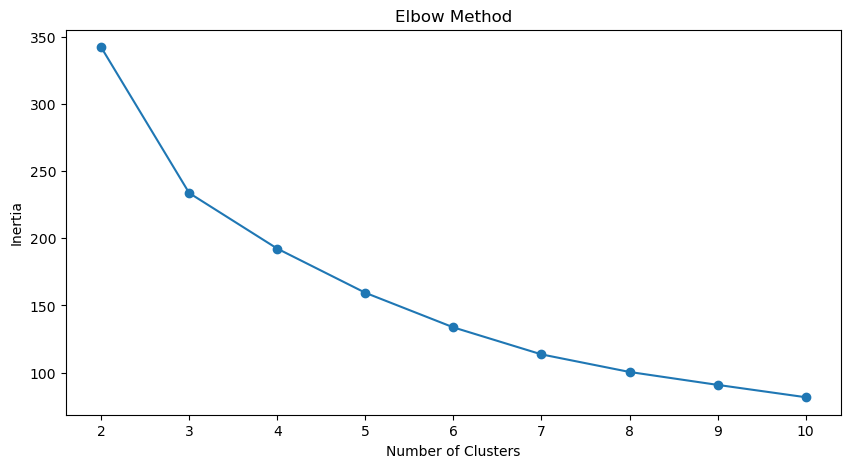

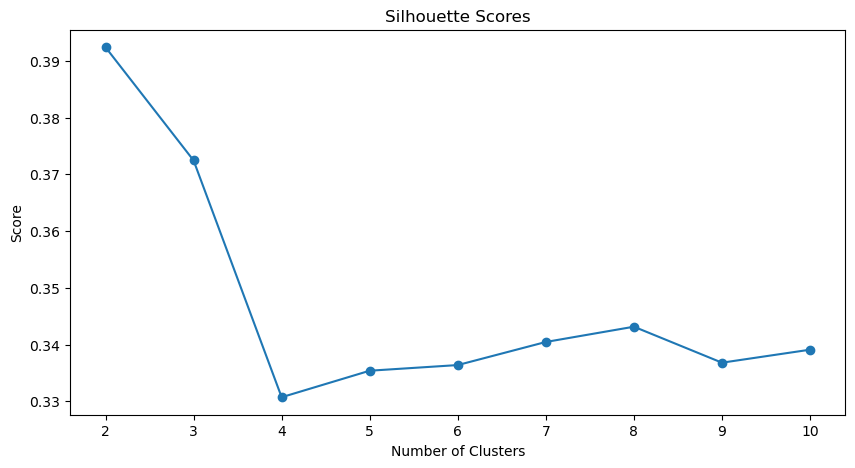

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []
silhouette_scores = []

for k in range(2, 11):  # Clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))
    
# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

#### Perform Clustering

In [10]:
# Apply KMeans with optimal clusters
optimal_clusters = 4  # Adjust based on the Elbow/Silhouette analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_agg['Cluster'] = kmeans.fit_predict(scaled_features)

# Cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

Cluster Centers:
[[-0.40410028 -0.7804868   1.03695404]
 [ 1.23800378  1.22186708  0.16623469]
 [-0.27639633 -0.07649342 -0.36758957]
 [-1.31526044 -1.05918879 -1.51362453]]


/Users/jaini/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Evaluate Clustering Performance

In [11]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_features, customer_agg['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.9448437495439577


#### Visualisation and Intrepretation

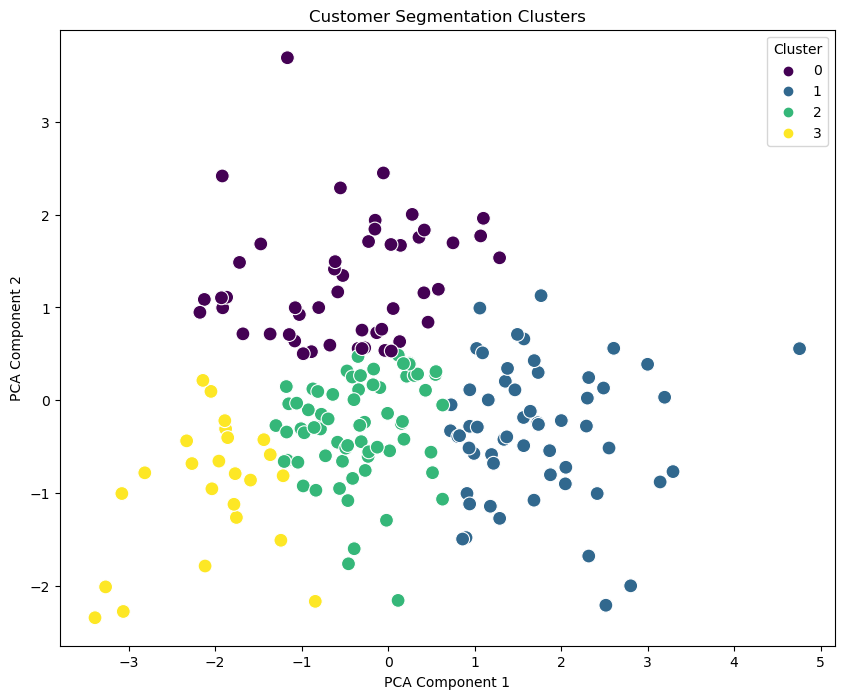

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2 dimensions
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA features to the dataframe
customer_agg['PCA1'] = pca_features[:, 0]
customer_agg['PCA2'] = pca_features[:, 1]

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_agg, palette='viridis', s=100
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [13]:
# Aggregate statistics per cluster
cluster_summary = customer_agg.groupby('Cluster').agg({
    'TotalValue': ['mean', 'sum'],
    'Quantity': ['mean', 'sum'],
    'Price': ['mean']
}).reset_index()

print(cluster_summary)

  Cluster   TotalValue              Quantity             Price
                  mean        sum       mean   sum        mean
0       0  2728.591800  136429.59   7.960000   398  343.827738
1       1  5730.468772  326636.72  20.245614  1154  283.308111
2       2  2962.043235  201418.94  12.279412   835  246.204485
3       3  1062.929583   25510.31   6.250000   150  166.548958
